### **Лабораторная работа 2**

_Ляхов Артём Андреевич БПМ211_

Вариант 10

Задания: 3.1.10, 3.4, 3.6.2

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

### __Задача 3.1.10__
#### Формулировка задачи
Дана система уравнений $Ax = b$ порядка $n$. Необходимо исследовать зависимость погрешности решения $x$ от погрешностей правой части система $b$.

Значения $a_{ij}$ матрицы $A$ и $b_i$ вектора $b$ задаются следующими соотношениями:
$$
a_{ij} = sin\left(\frac{c_{ij}}{8}\right),\ \ \ c_{ij}=0.1\cdot N \cdot i \cdot j,\ \ \ b_i=N
$$
где $N=10$ - номер варианта, $n=5$ - порядок системы.

In [23]:
n, N = 5, 10

A = np.zeros(shape=(n, n), dtype=np.double)
b = np.full(shape=n, fill_value=N, dtype=np.double)

for i, j in itertools.product(range(n), range(n)):
    c = 0.1 * N * (i + 1) * (j + 1)
    A[i, j] = np.sin(c/8)

In [24]:
x = np.linalg.solve(A, b)
cond = np.linalg.cond(A, p=np.inf)

In [25]:
def get_d(x_true, x_approx):
    """
    Calculates d for true vector x_true and approximate vector x_approx.
    """
    return np.linalg.norm(x_true - x_approx, ord=np.inf)/np.linalg.norm(x_true, ord=np.inf)

In [26]:
d_vec = np.zeros(n, dtype=np.double)
delta = 0.5

for i in range(n):
    b_mod = b.copy()
    b_mod[i] += delta
    x_mod = np.linalg.solve(A, b_mod)
    d_vec[i] = get_d(x, x_mod)

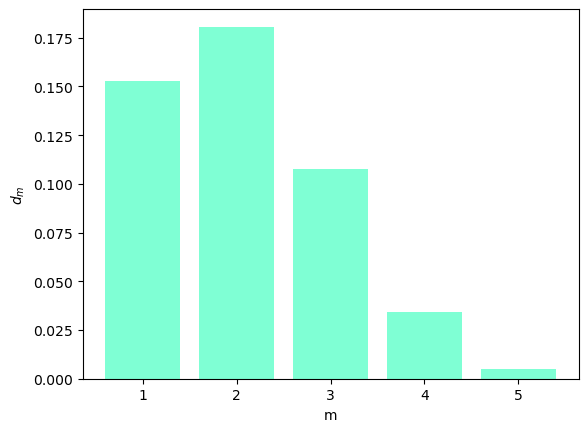

In [27]:
plt.bar(x=range(1, n+1), height=d_vec, color='aquamarine')

plt.xlabel('m')
plt.ylabel('$d_m$')

plt.savefig('plots\problem1_precision.png', format='png')
plt.show()

In [7]:
m_max = np.argmax(d_vec)

b_max = b.copy()
b_max[m_max] += delta

x_max = np.linalg.solve(A, b_max)

delta_x = get_d(x, x_max)
delta_b = get_d(b, b_max)
delta_max = cond * delta_b 

In [10]:
np.round(d_vec, 4)

array([0.1529, 0.1807, 0.1075, 0.0345, 0.0048])

In [30]:
print(f"m = {m_max + 1}")
print(f"cond(A) = {cond:.4f}")
print(f"delta(b^m) = {delta_b:.4f}")
print(f"delta(x^m) = {delta_x:.4f}")

print()

print("Неравенство:")
print(f"{delta_x:.4f} <= {delta_max:.4f}")

m = 2
cond(A) = 7690516.4277
delta(b^m) = 0.0500
delta(x^m) = 0.1807

Неравенство:
0.1807 <= 384525.8214


### __Задача 3.4__
#### Формулировка задачи
Требуется решить систему уравнений $Ax=b$ из _задачи 3.1_, используя LU-разложение матрицы $A$.

In [12]:
def lu(A: np.ndarray):
    """
    Computes LU decomposition of matrix with partitial pivoting

    :param np.ndarray A: array to decompose. Must be 2-dimensional and be square matrix.
    :return: P, L, U matrices: P - permutation matrix, 
                               L - lower triangular matrix, 
                               U - upper triangular matrix.
    """
    n = A.shape[0]

    U = A.copy()
    L, P = np.eye(n, dtype=float), np.eye(n, dtype=float)

    for i in range(n):
        # Partitial pivoting
        for k in range(i, n):
            if ~np.isclose(U[i, i], 0.0):
                break
            U[[i, k]] = U[[k, i]]
            P[[i, k]] = U[[k, i]]
        
        factor = U[i+1:, i] / U[i, i]
        L[i+1:, i] = factor
        U[i+1:] -= factor[:, None] * U[i]
    
    return P, L, U


def forward_substitution(L, b):
    """
    Returns a solution y of linear system Ly = b, aka
    performs forward substitution in solution of system LUx=b.

    :param np.ndarray L: lower-triangular matrix L from LU-decomposition.
    :param np.ndarray b: vector - right part of system Ax=b or LUx=b.
    :return np.ndarray: solution of the system Ly=b. 
    """
    n = L.shape[0]
    y = np.zeros(n, dtype=float)
    for i in range(n):
        y[i] = (b[i] - L[i, :i] @ y[:i]) / L[i, i]
    return y


def back_substitution(U, y):
    """
    Returns a solution of linear system Ux = y, aka 
    performs back substitution in solution of linear system LUx = b.

    :param np.ndarray U: upper-triangular matrix U from LU-decomposition.
    :param np.ndarray y: solution of system Ly=b (see forward_substitution).
    :return np.ndarray: solution of the system Ux=y, aka solution of system LUx=b.
    """
    
    n = U.shape[0]
    x = np.zeros(n, dtype=float)
    for i in reversed(range(n)):
        x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]
    return x
    

def solve_lu(A, b):
    """
    Solves a system of linear equations using LU-decomposition.

    :param np.ndarray A: coefficient matrix.
    :param np.ndarray b: ordinate or “dependent variable” values.
    :return np.ndarray: solution to the system Ax=b. 
    """
    n = A.shape[0]
    P, L, U = lu(A)

    b = P @ b
    y = forward_substitution(L, b)
    return back_substitution(U, y)

In [13]:
print("Решение системы, найденное с помощью LU-разложения:")
print(solve_lu(A, b).reshape(-1, 1))

Решение системы, найденное с помощью LU-разложения:
[[ 1732046.00042832]
 [-2052111.22450604]
 [ 1226346.77320945]
 [ -395911.8919326 ]
 [   55377.46940079]]


In [14]:
np.allclose(solve_lu(A, b), x)

True

In [15]:
get_d(solve_lu(A, b), x)

7.625244129646137e-11

### __Задача 3.6.2__
#### Формулировка задачи
Дана система уравнений $Ax=b$ порядка $n$, где $A=A(t)$, $t$-параметр. Исследовать зависимость решения системы $Ax=b$ от вычислительной погрешности при заданных значениях параметра $t$.

Значения $A_{ij}$ матрицы $A$ задаются соотношением:
$$
A_{ij} = \begin{cases}
            q_{M}^j,\ \ i \ne j \\
            q_{M}^{j} + t,\ \ i = j 
         \end{cases}
$$
где $q_{M} = 0.993 + (-1)^M \cdot M \cdot 10^{-4}$, параметр $t$ принимает значения $0.0001$, $1$, $10000$. Элементы вектора $b$ вычисляются как $b_{j} = q_{M}^{n+1-j}$. При этом по условию варианта $M=2$, $n=100$, $m=5$.

In [40]:
def get_A(n, M, t, m = None):
    """
    Returns A matrix according to the condition.
    """
    q = 0.993 + ((-1) ** M) * M * 1e-4 
    A = np.zeros((n, n), dtype=float)
    
    for i, j in itertools.product(range(n), range(n)):
        A[i, i] = (q ** j) if i != j else (q ** j) + t
        
    return A if m is None else np.round(A, m)


def get_b(n, M, m = None):
    """
    Returns b vector according to the condition. 
    """
    q = 0.993 + ((-1) ** M) * M * 1e-4
    b = np.zeros(n, dtype=float)

    for j in range(n):
        b[j] = q ** (n + 1 - j)
        
    return b if m is None else np.round(b, m)

In [41]:
def solve_gauss(A, b, m = None):
    """
    Solves a system of equations by the Gauss method.

    :param np.ndarray A: coefficient matrix.
    :param np.ndarray b: ordinate or "dependent variable" values.
    :return np.ndarray x: solution to the system Ax=b.
    """
    n = A.shape[0]
    a = np.concatenate((A, b.reshape(-1, 1)), axis=1)

    for i in range(n):
        j = np.argmax(np.abs(a[i, i:-1])) + i
        a[[i, j]] = a[[j, i]]

        if np.isclose(a[i, i], 0):
            continue

        for k in range(i+1, n):
            ratio = a[k, i]/a[i, i]
            a[k] = a[k] - ratio * a[i]

        if m is not None:
            a = np.round(a, m)
    
    x = np.zeros(n, dtype=float)
    for i in reversed(range(n)):
        value = (a[i, -1] - x[i+1:] @ a[i, i+1:-1]) / a[i, i]
        x[i] = value if m is None else np.round(value, m)

    return x

In [46]:
def absolute_error(x_true, x_approx, ord=1):
    return np.linalg.norm(x_true - x_approx, ord=ord)


def relative_error(x_true, x_approx, ord=1):
    err = absolute_error(x_true, x_approx, ord)
    return err/np.linalg.norm(x_true, ord=ord)

#### Проверка корректности
Здесь и далее в качестве расстояния между решениями будем использовать норму разности, где 
$||x|| = ||x||_{1} = \sum\limits_{i=1}^{n}|x_i|$

In [48]:
mat = np.random.randint(-10, 11, size=(5, 5)).astype(float)
vec = np.random.randint(-5, 5, size=5).astype(float)

x_method = solve_gauss(mat, vec)
x_true = np.linalg.solve(mat, vec)

print(f"Absolute error: {absolute_error(x_true, x_method)}")
print(f"Relative error: {relative_error(x_true, x_method)}")

Absolute error: 6.036837696399289e-16
Relative error: 4.316088836974617e-16


In [52]:
M, n, m = 2, 100, 5
t_list = [1e-4, 1, 10_000]

In [54]:
for t in t_list:
    A = get_A(n, M, t)
    b = get_b(n, M)

    A1 = get_A(n, M, t, m)
    b1 = get_b(n, M, m)

    x = solve_gauss(A, b)
    x1 = solve_gauss(A1, b1, m)

    print(f"t = {t}")
    print(f"Absolute error: {absolute_error(x, x1)}")
    print(f"Relative error: {relative_error(x, x1)}")
    print()

t = 0.0001
Absolute error: 0.0007469482645003911
Relative error: 5.2983920272805855e-06

t = 1
Absolute error: 0.0007276038415945374
Relative error: 5.208623428252422e-06

t = 10000
Absolute error: 0.0007280435716826997
Relative error: 5.236273025617739e-06

